In [1]:
sc

In [2]:
from pyspark import SparkContext

logFile = "README.md"  # Should be some file on your system
#sc = SparkContext("local", "Simple App1")
logData = sc.textFile(logFile).cache()

numAs = logData.filter(lambda s: 'a' in s).count()
numBs = logData.filter(lambda s: 'b' in s).count()

print "Lines with a: %i, lines with b: %i" % (numAs, numBs)


Lines with a: 11, lines with b: 6


In [3]:
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vectors

from scipy.sparse import csr_matrix

from pyspark.mllib.linalg import Matrix
from pyspark.mllib.linalg import Matrices

In [4]:
def demo():
    # Load and parse the data
    data = sc.textFile("/home/carlosm/Projects/Sherlock/spark-1.5.1/data/mllib/sample_lda_data.txt")
    parsedData = data.map(lambda line: Vectors.dense([float(x) for x in line.strip().split(' ')]))
    # Index documents with unique IDs
    corpus = parsedData.zipWithIndex().map(lambda x: [x[1], x[0]]).cache()

    # Cluster the documents into three topics using LDA
    ldaModel = LDA.train(corpus, k=3)

    # Output topics. Each is a distribution over words (matching word count vectors)
    print("Learned topics (as distributions over vocab of " + str(ldaModel.vocabSize()) + " words):")
    topics = ldaModel.topicsMatrix()
    for topic in range(3):
        print("Topic " + str(topic) + ":")
        for word in range(0, ldaModel.vocabSize()):
            print(" " + str(topics[word][topic]))
demo()

Learned topics (as distributions over vocab of 11 words):
Topic 0:
 10.8703032824
 7.58710309535
 3.46277705472
 20.5523015822
 15.1936810928
 7.67066234949
 6.28884032069
 6.16585502983
 0.916147888544
 3.52466597781
 4.72159916
Topic 1:
 5.91497934516
 14.4556220044
 5.59955439908
 8.84484324037
 3.57131682699
 6.52195991022
 9.75259352336
 1.33951669725
 3.93772803027
 12.9356325852
 14.1623544114
Topic 2:
 9.21471737247
 6.95727490025
 2.9376685462
 10.6028551774
 6.23500208023
 7.80737774029
 14.9585661559
 2.49462827293
 3.14612408119
 7.53970143701
 14.1160464286


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import pandas as pd
from wordcloud import WordCloud
import gensim

# Load data_vraag from file

In [7]:
import pickle
data_vraag = pickle.load(open('preprocessedData.pkl', 'r'))

In [8]:
data_ppl = data_vraag[data_vraag['individu of groep']=='mijzelf']
data_org = data_vraag[data_vraag['individu of groep']!='mijzelf']

In [9]:
vraagTokens = data_vraag['SentToks'].tolist()

In [10]:
dic = gensim.corpora.Dictionary(vraagTokens)
corpus = [dic.doc2bow(text) for text in vraagTokens]

In [11]:
def lineToSparse(line):
    v = [float(x) for x in line.strip().split(' ')]
    v = { idx: v[idx] for idx,val in zip(np.nonzero(v)[0], v) }
    v = Vectors.sparse(11, v)
    return v


In [12]:
def toSparseVector(corpusLine, nFeatures):
    v = { idx: val for idx,val in corpusLine }
    return Vectors.sparse(nFeatures, v)

# nSamples = len(corpus)
nFeatures = len(dic)

corpusParallel = sc.parallelize(corpus)
corpusMapped = corpusParallel.map(lambda doc: toSparseVector(doc, nFeatures))

# Index documents with unique IDs
corpusIndexed = corpusMapped.zipWithIndex().map(lambda x: [x[1], x[0]]).cache()

In [13]:
nTopics = 10
ldaModel = LDA.train(corpusIndexed, k=nTopics)

In [14]:
from sklearn.decomposition import LatentDirichletAllocation

In [18]:
# Embed fitted matrix into sklearn LDA

lda = LatentDirichletAllocation(n_topics=nTopics, max_iter=1,
                                learning_method='online', learning_offset=50.
                                #,random_state=0
                               )
doc0 = corpusIndexed.first()[1].toArray()
lda.fit(doc0)
lda.components_ = ldaModel.topicsMatrix().T


In [19]:
def getDocumentTopics(docTokens, lda):
    wcTuples = dic.doc2bow(docTokens)
    data = []
    row  = []
    col  = []

    for w,c in wcTuples:
        col.append(0)
        row.append(w)
        data.append(c)

    nSamples = 1
    nFeatures = len(dic)
    oneDoc = csr_matrix((data, (col,row)), shape=(nSamples, nFeatures))
    docWeights = lda.transform(oneDoc)[0]
    docWeights /= docWeights.sum()
    return docWeights

In [20]:
def inRange(age, targetAge, delta):
    return (targetAge-delta)<=age and age<=(targetAge+delta)

def getPplCirca(targetAge, delta):
    return data_ppl[data_ppl['Leeftijd'].apply(lambda age: inRange(age,targetAge, delta))]

In [21]:
topicsByAge = np.zeros((data_ppl['Leeftijd'].max()+1, nTopics))
deltaAge = 5

for age in arange(data_ppl['Leeftijd'].max()+1): 
    dataGroup = getPplCirca(age,deltaAge)
    groupTokens = dataGroup['SentToks'].tolist()
    
    for qTokens in groupTokens:
        topicWeights = getDocumentTopics(qTokens, lda)
        for topic,weight in enumerate(topicWeights):
            topicsByAge[age,topic] += weight / len(groupTokens)

In [22]:
topicWords = []
topicWeightedWords = []

for topic_idx, topic in enumerate(lda.components_):
    weightedWordIdx = topic.argsort()[::-1]
    wordsInTopic = [dic[i] for i in weightedWordIdx[:10]]

    weights = topic / topic.sum()
    topicWeights = [ (weights[i],dic[i]) for i in weightedWordIdx[:10]]
    
    print "Topic #%d:" % topic_idx
    print " ".join(wordsInTopic)
    topicWords.append(wordsInTopic)
    topicWeightedWords.append(topicWeights)

Topic #0:
mensen onderzoek vraag nieuwe steeds maken mogelijk nodig nederland grote
Topic #1:
onderzoek mensen nederland ontwikkeling nieuwe vraag nederlandse maken gebied kinderen
Topic #2:
mensen vraag onderzoek nieuwe kennis maken mogelijk steeds nederland waarom
Topic #3:
mensen nieuwe onderzoek maken economie mogelijk vraag steeds groot energie
Topic #4:
nieuwe mensen steeds mogelijk onderzoek maken grote weten nodig vraag
Topic #5:
kinderen mensen onderzoek ontwikkeling maken vraag samenleving nieuwe steeds nederland
Topic #6:
mensen nieuwe onderzoek vraag steeds maken mogelijk grote nederland waarom
Topic #7:
mensen onderzoek vraag maken mogelijk nieuwe waarom nederland kinderen steeds
Topic #8:
mensen onderzoek steeds vraag waarom mogelijk maken nieuwe wel goed
Topic #9:
mensen nieuwe steeds onderzoek maken grote mogelijk leven vraag systemen


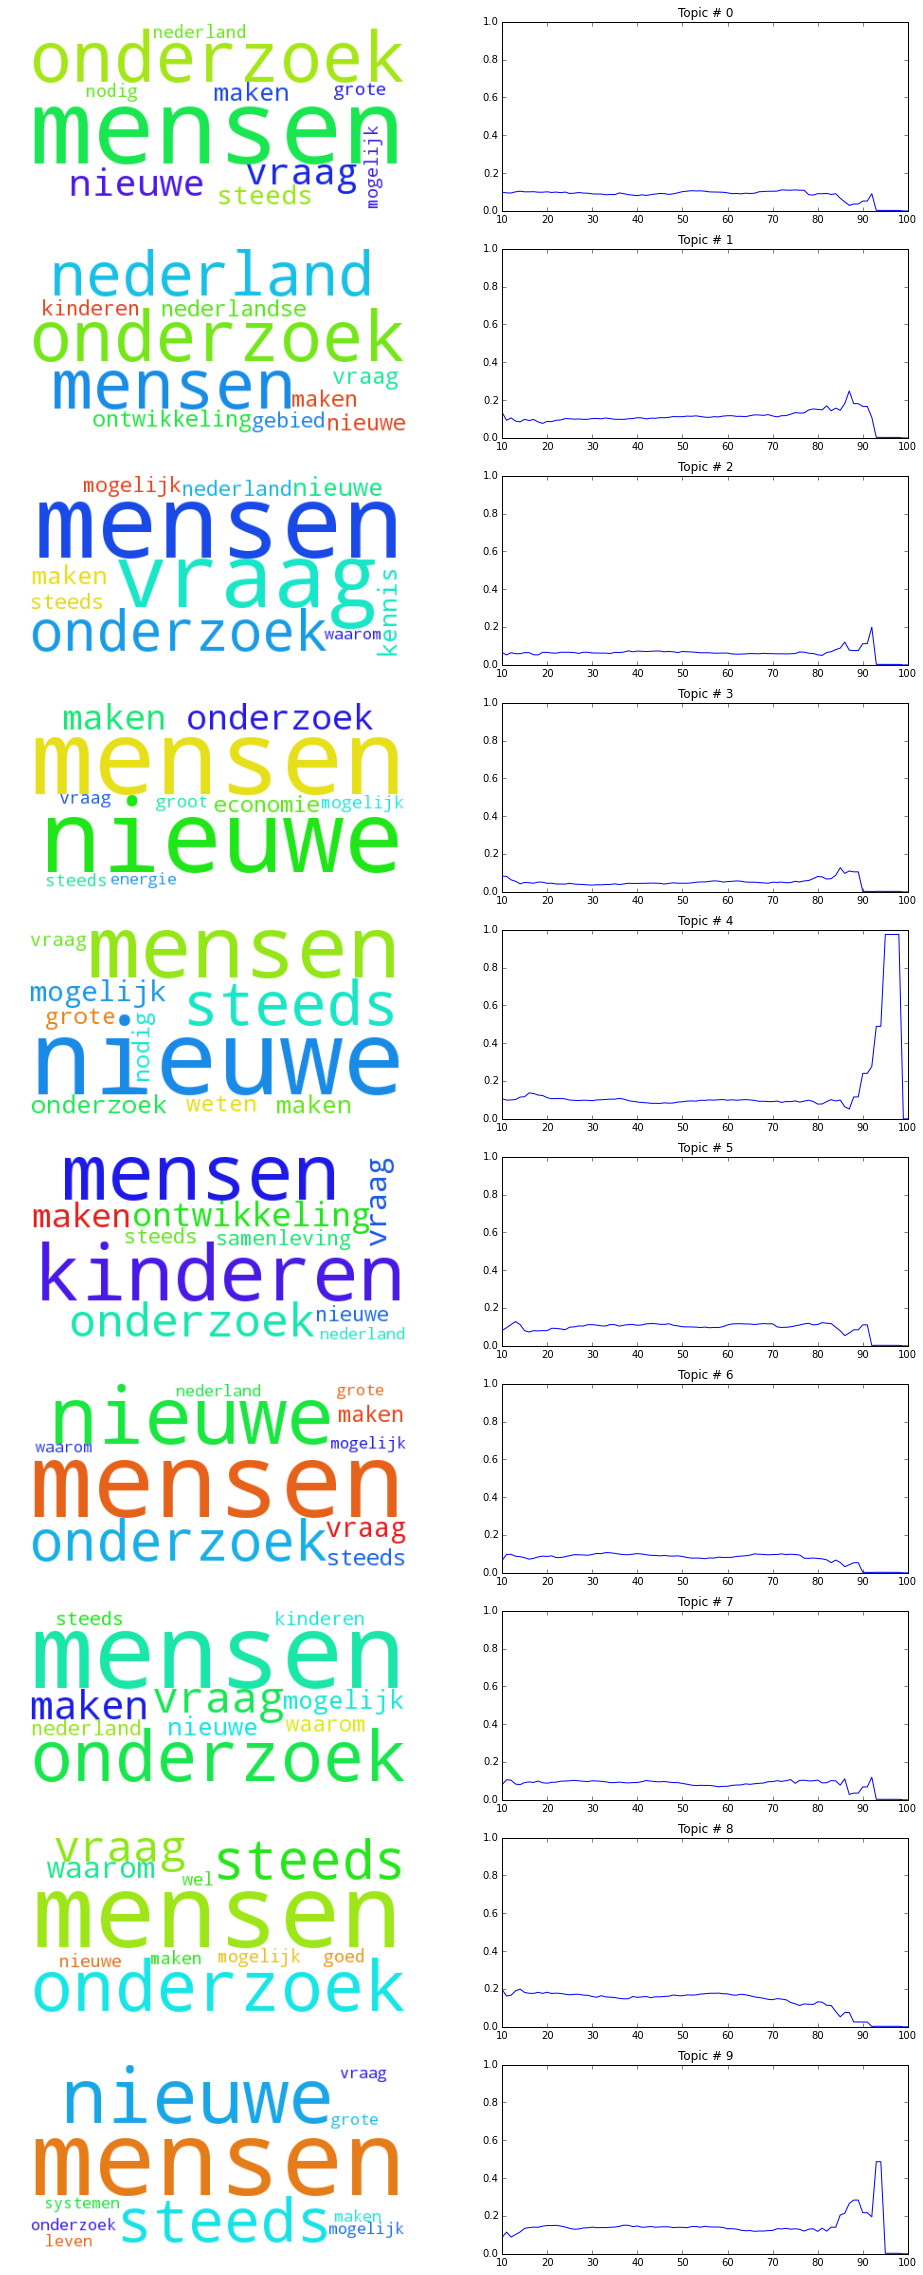

In [24]:
figure(figsize=(16,40))
for idx,topic in enumerate(topicWeightedWords):
    wc = WordCloud(background_color="white")
    img = wc.generate_from_frequencies([ (word, weight) for weight,word in topic ])
    subplot(nTopics,2,2*idx+1)
    imshow(img)
    axis('off')
    
    subplot(nTopics,2,2*idx+2)
    plot(topicsByAge[:,idx])
    axis([10, 100, 0, 1.0])
    title('Topic #%2d'%(idx))